In [1]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap

from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import DiagonalGaussianHMM
from dynamax.hidden_markov_model import SphericalGaussianHMM
from dynamax.hidden_markov_model import SharedCovarianceGaussianHMM
from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

I0000 00:00:1725647489.579755  322342 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
plt.rcParams["font.family"] = "Times New Roman"

In [38]:
# Helper functions for plotting
def plot_gaussian_hmm(hmm, params, emissions, states,  title="Emission Distributions", alpha=0.25):
    lim = 1.1 * abs(emissions).max()
    XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), jnp.linspace(-lim, lim, 100))
    grid = jnp.column_stack((XX.ravel(), YY.ravel()))

    plt.figure(figsize=(4,4),dpi=400)
    for k in range(hmm.num_states):
        lls = hmm.emission_distribution(params, k).log_prob(grid)
        plt.contour(XX, YY, jnp.exp(lls).reshape(XX.shape), cmap=white_to_color_cmap(COLORS[k]))
        plt.plot(emissions[states == k, 0], emissions[states == k, 1], "o", mfc=COLORS[k], mec="none", ms=3, alpha=alpha)

    plt.plot(emissions[:, 0], emissions[:, 1], "-k", lw=1, alpha=alpha)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title(title)
    plt.gca().set_aspect(1.0)
    plt.tight_layout()


def plot_gaussian_hmm_data(hmm, params, emissions, states, xlim=None):
    num_timesteps = len(emissions)
    emission_dim = hmm.emission_dim
    means = params.emissions.means[states]
    lim = 1.05 * abs(emissions).max()

    # Plot the data superimposed on the generating state sequence
    fig, axs = plt.subplots(emission_dim, 1, sharex=True)
    
    for d in range(emission_dim):    
        axs[d].imshow(states[None, :], aspect="auto", interpolation="none", cmap=CMAP,
                      vmin=0, vmax=len(COLORS) - 1, extent=(0, num_timesteps, -lim, lim))
        axs[d].plot(emissions[:, d], "-k")
        axs[d].plot(means[:, d], ":k")
        axs[d].set_ylabel("$y_{{t,{} }}$".format(d+1))
        
    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)

    axs[-1].set_xlabel("time")
    axs[0].set_title("Simulated data from an HMM")
    plt.tight_layout()

In [39]:
num_train_batches = 3
num_test_batches = 1
num_timesteps = 100

# Make an HMM and sample data and true underlying states
true_num_states = 3
emission_dim = 2
hmm = GaussianHMM(true_num_states, emission_dim)

# Specify parameters of the HMM
initial_probs = jnp.ones(true_num_states) / true_num_states
transition_matrix = 0.80 * jnp.eye(true_num_states) \
    + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1) \
    + 0.05 / true_num_states
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.zeros((true_num_states, emission_dim - 2)),
    ])
emission_covs = jnp.tile(0.1**2 * jnp.eye(emission_dim), (true_num_states, 1, 1))
        
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)

# Sample train, validation, and test data
train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)
f = vmap(partial(hmm.sample, true_params, num_timesteps=num_timesteps))
train_true_states, train_emissions = f(jr.split(train_key, num_train_batches))
test_true_states,  test_emissions  = f(jr.split(test_key, num_test_batches))

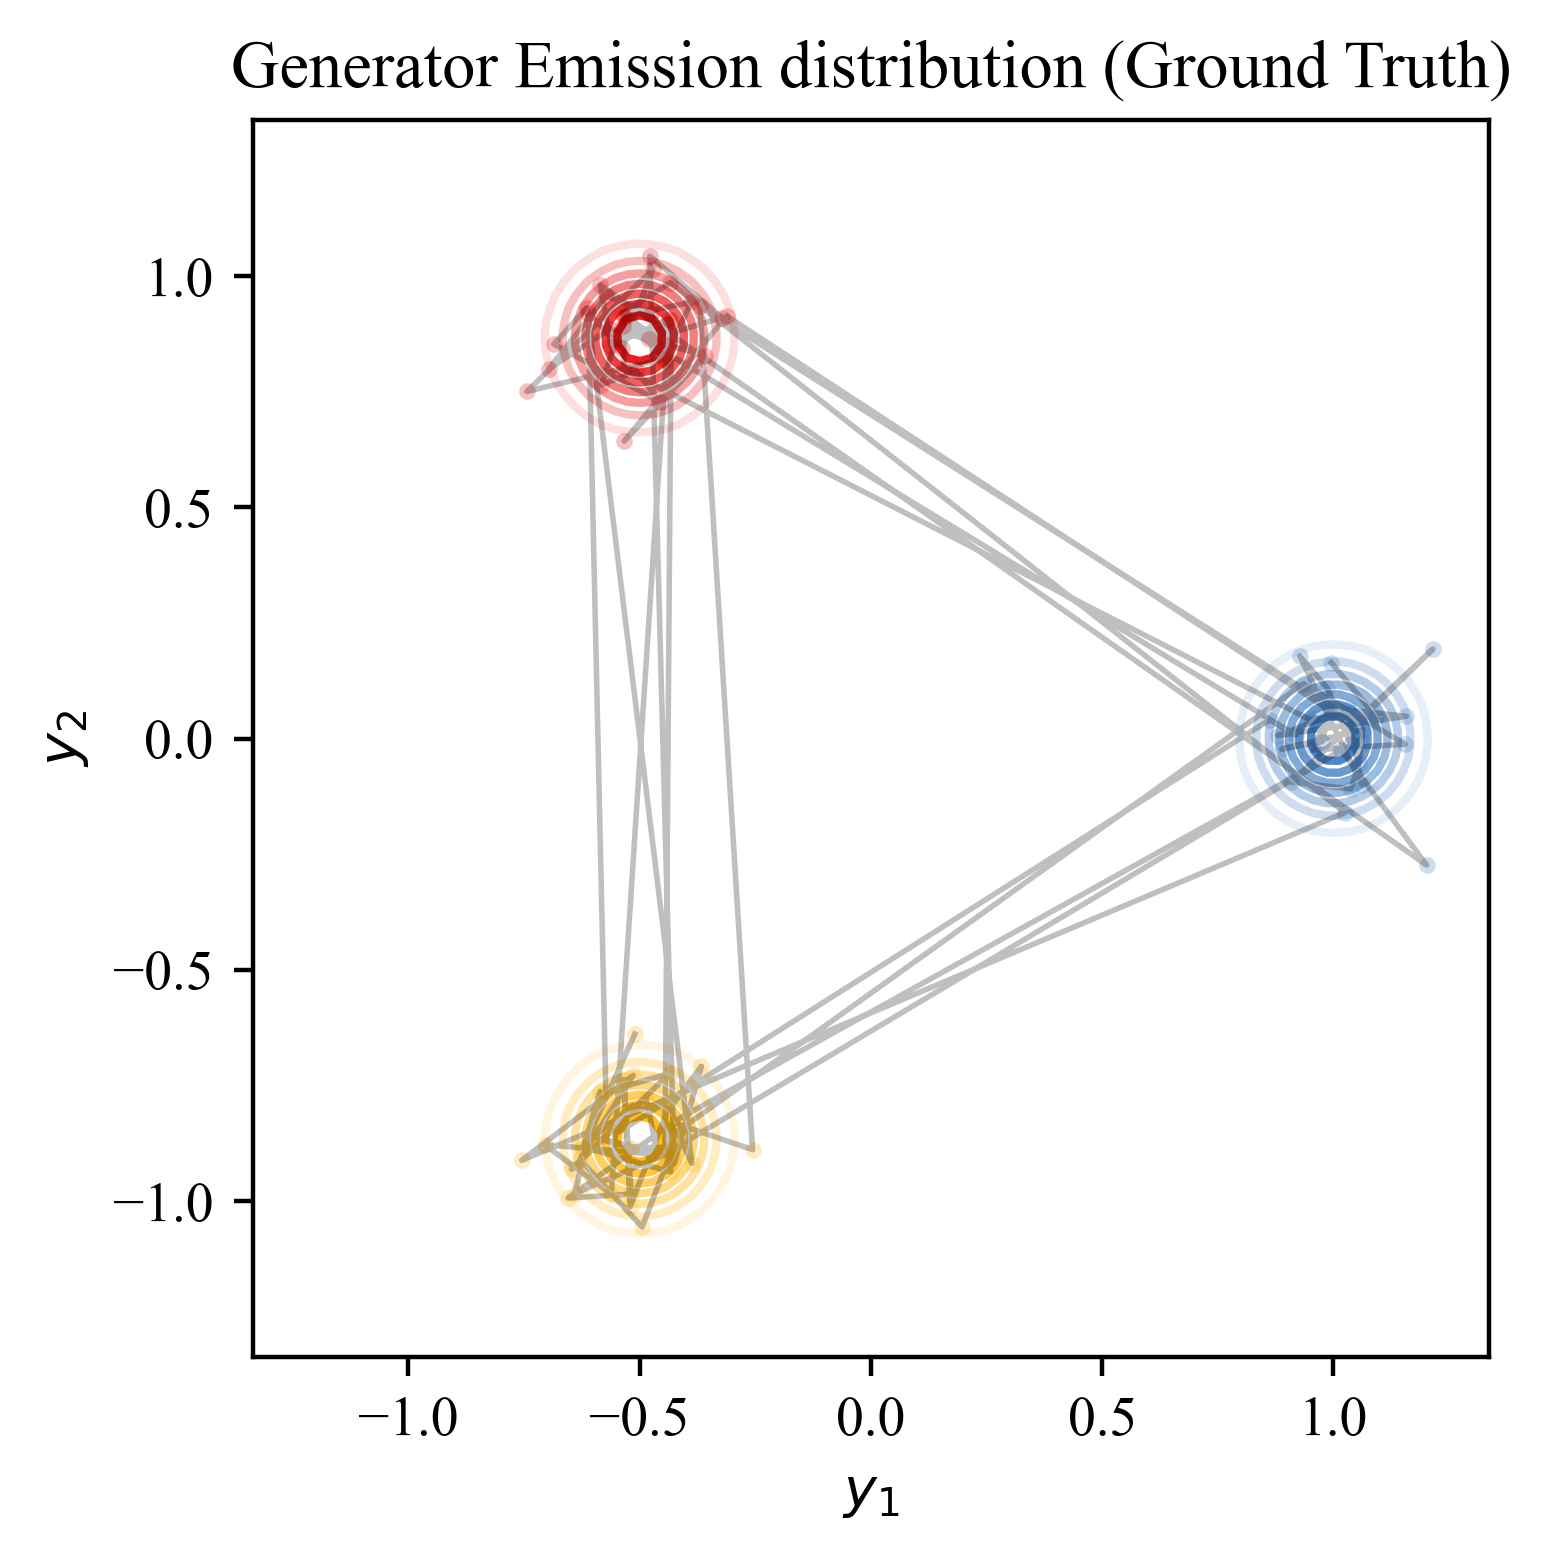

In [40]:
# Plot emissions and true_states in the emissions plane
plot_gaussian_hmm(hmm, true_params, train_emissions[0], train_true_states[0], 
                  title="Generator Emission distribution (Ground Truth)")

In [6]:
def cross_validate_model(model, key, num_iters=100):
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(key=key, method="kmeans", emissions=train_emissions)
    
    # Split the training data into folds.
    # Note: this is memory inefficient but it highlights the use of vmap.
    folds = jnp.stack([
        jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
        for i in range(num_train_batches)
    ])
    
    def _fit_fold(y_train, y_val):
        fit_params, train_lps = model.fit_em(params, props, y_train, 
                                             num_iters=num_iters, verbose=False)
        return model.marginal_log_prob(fit_params, y_val)

    val_lls = vmap(_fit_fold)(folds, train_emissions)
    return val_lls.mean(), val_lls


In [7]:
# Make a range of Gaussian HMMs
all_num_states = list(range(2, 10))
test_hmms = [GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.) 
          for num_states in all_num_states]
results = []
for test_hmm in test_hmms:
    print(f"fitting model with {test_hmm.num_states} states")
    results.append(cross_validate_model(test_hmm, jr.PRNGKey(0)))
    
avg_val_lls, all_val_lls = tuple(zip(*results))

fitting model with 2 states


/home/nuttidalab/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


fitting model with 3 states


/home/nuttidalab/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


fitting model with 4 states


/home/nuttidalab/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


fitting model with 5 states


/home/nuttidalab/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


fitting model with 6 states


/home/nuttidalab/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


fitting model with 7 states


/home/nuttidalab/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


fitting model with 8 states


/home/nuttidalab/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


fitting model with 9 states


/home/nuttidalab/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0, 0.5, 'avg. validation log prob.')

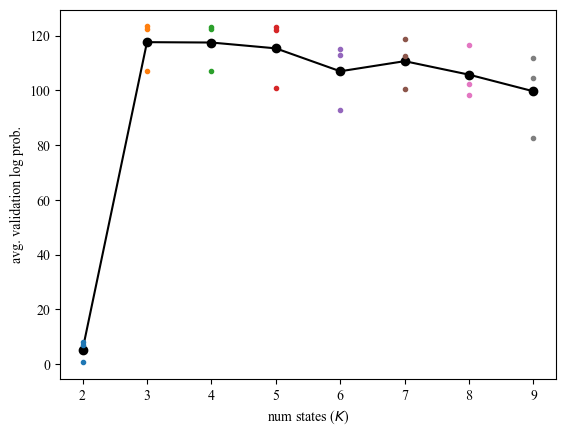

In [8]:
plt.plot(all_num_states, avg_val_lls, '-ko')
for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")

In [9]:
best_num_states = all_num_states[jnp.argmax(jnp.stack(avg_val_lls))]
print("best number of states:", best_num_states)

best number of states: 3


In [34]:
# Initialize the parameters using K-Means on the full training set
key = jr.PRNGKey(0)
test_hmm = GaussianHMM(best_num_states, emission_dim, transition_matrix_stickiness=10.)
params, props = test_hmm.initialize(key=key, method="kmeans", emissions=train_emissions)
params, lps = test_hmm.fit_em(params, props, train_emissions, num_iters=100)

/home/nuttidalab/miniconda3/envs/ssm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


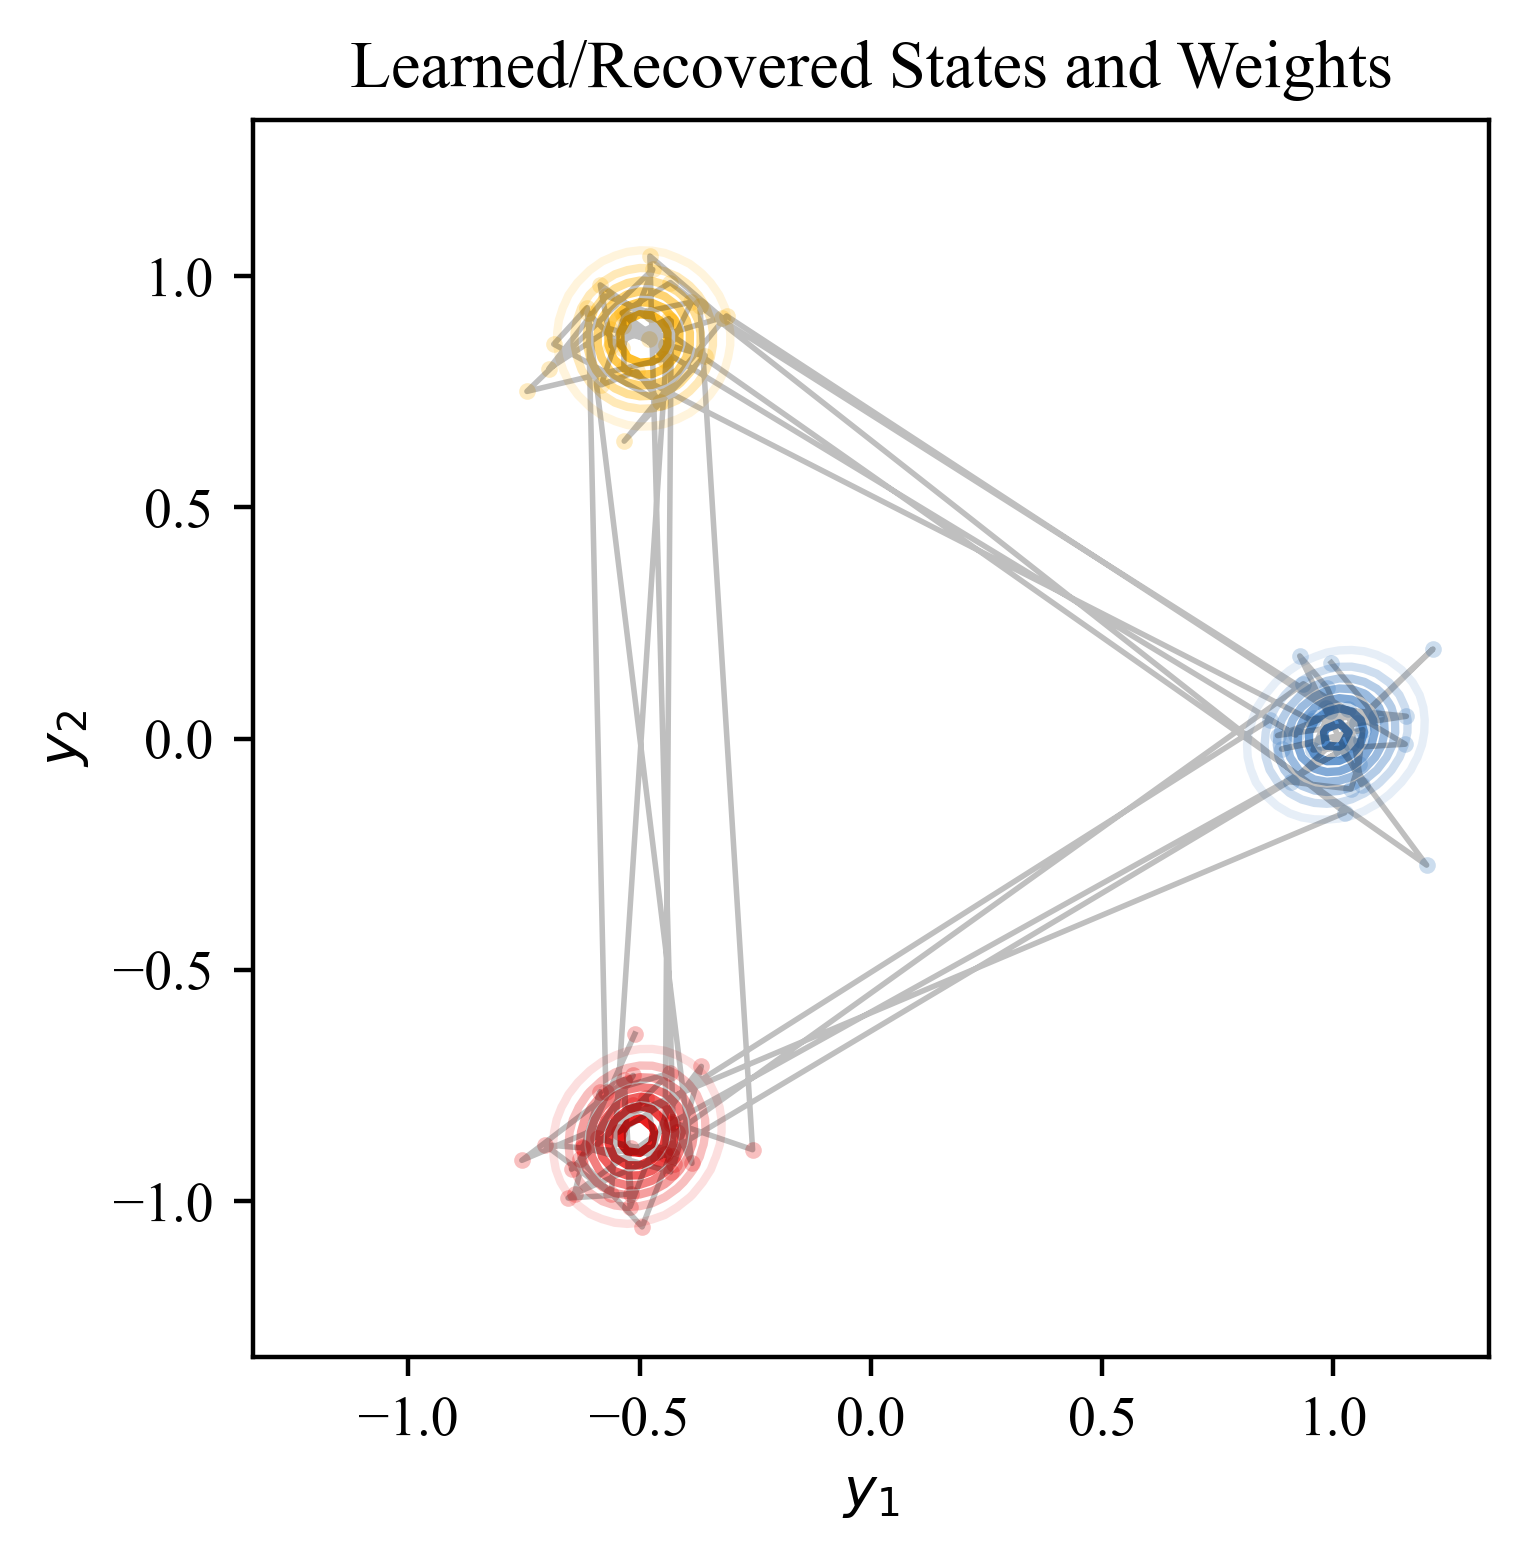

In [41]:
most_likely_states = test_hmm.most_likely_states(params, train_emissions[0])
plot_gaussian_hmm(test_hmm, params, train_emissions[0], most_likely_states, 
                  title=f"Learned/Recovered States and Weights", alpha=0.25)